
✅ Dataset loaded: (1330816, 13)
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17  

--- N

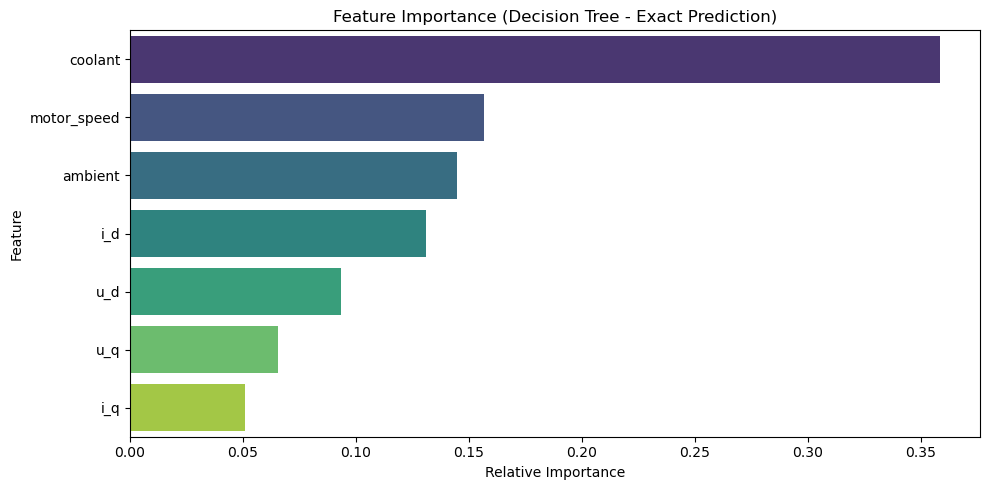


🔍 Verification:
Max difference: 0.000002
Mean difference: 0.000000

🌡️ Sample Row Prediction -> True: 24.554214, Predicted: 24.554214


In [1]:
# ==========================================
# ⚡ Exact Prediction Model Trainer (Multi-Model Comparison + Final Decision Tree)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import joblib

warnings.filterwarnings('ignore')

# ==========================================
# Load dataset
# ==========================================
df = pd.read_csv('D:/VMK/flask_app/measures_v2.csv')
print(f"\n✅ Dataset loaded: {df.shape}")
print(df.head())

# Drop profile_id if exists
if 'profile_id' in df.columns:
    df.drop(columns=['profile_id'], inplace=True)

# Drop unnecessary columns if they exist
drop_cols = ['stator_yoke', 'stator_tooth', 'stator_winding', 'torque']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Check nulls
print("\n--- Null values ---")
print(df.isnull().sum())

# ==========================================
# Define features and target
# ==========================================
features = [col for col in df.columns if col != 'pm']
X = df[features]
y = df['pm']

# ==========================================
# Feature scaling
# ==========================================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'transform_exact.save')

# ==========================================
# Train and Compare Multiple Models
# ==========================================
print("\n--- ⚡ Model Comparison ---")

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=None),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
}

results = {}
best_model = None
best_name = None
best_r2 = -float("inf")

for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    r2 = metrics.r2_score(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    mae = metrics.mean_absolute_error(y, y_pred)
    results[name] = (r2, rmse, mae)
    print(f"{name:20s} -> R²={r2:.6f} | RMSE={rmse:.4f} | MAE={mae:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_name = name

print(f"\n✅ Best model based on R²: {best_name} (R²={best_r2:.6f})")

# ==========================================
# Final Model Training (Decision Tree for Exact Prediction)
# ==========================================
print("\n🌲 Training final Decision Tree model on full dataset (for exact prediction)...")

model = DecisionTreeRegressor(
    random_state=42,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)
model.fit(X_scaled, y)
joblib.dump(model, 'model_exact.save')

print(f"\n✅ Final Decision Tree model trained and saved successfully as 'model_exact.save'")

# ==========================================
# Feature Importance
# ==========================================
if hasattr(model, "feature_importances_"):
    feature_importance = model.feature_importances_
    feature_df = pd.DataFrame({
        "Feature": features,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
    plt.title("Feature Importance (Decision Tree - Exact Prediction)")
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# ==========================================
# Verification
# ==========================================
y_pred = model.predict(X_scaled)
differences = y - y_pred
print(f"\n🔍 Verification:")
print(f"Max difference: {np.max(np.abs(differences)):.6f}")
print(f"Mean difference: {np.mean(np.abs(differences)):.6f}")

# ==========================================
# Example Row Prediction
# ==========================================
sample_index = 0
sample_input = X.iloc[sample_index].values.reshape(1, -1)
sample_scaled = scaler.transform(sample_input)
predicted_temp = model.predict(sample_scaled)[0]
print(f"\n🌡️ Sample Row Prediction -> True: {y.iloc[sample_index]:.6f}, Predicted: {predicted_temp:.6f}")
